In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 99% 329M/331M [00:18<00:00, 21.2MB/s]
100% 331M/331M [00:18<00:00, 18.8MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
base_directory='/content/UTKFace'

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [6]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(base_directory)):
    image_path = os.path.join(base_directory, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [7]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/40_0_3_20170119204122502.jpg....,40,0
1,/content/UTKFace/28_0_0_20170105162616443.jpg....,28,0
2,/content/UTKFace/40_0_0_20170113135437140.jpg....,40,0
3,/content/UTKFace/26_0_0_20170113210319156.jpg....,26,0
4,/content/UTKFace/24_0_2_20170116164209154.jpg....,24,0


In [8]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

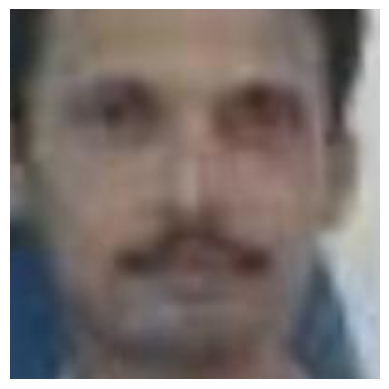

In [9]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

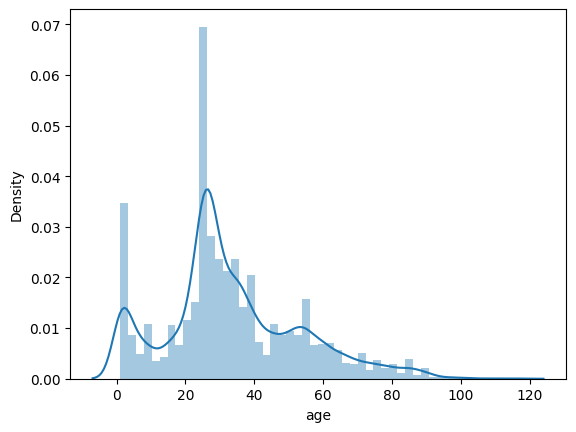

In [10]:
sns.distplot(df['age'])


In [11]:
print(df['gender'].value_counts())


0    12391
1    11317
Name: gender, dtype: int64


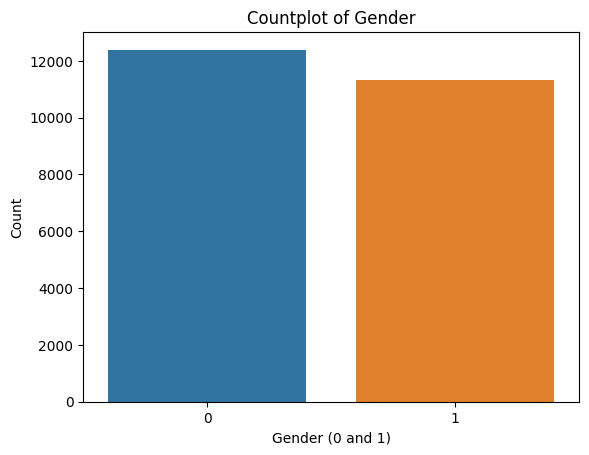

In [12]:
sns.countplot(x='gender', data=df)
plt.title('Countplot of Gender')
plt.xlabel('Gender (0 and 1)')
plt.ylabel('Count')
plt.show()


In [13]:
print(df['gender'].isnull().sum())


0


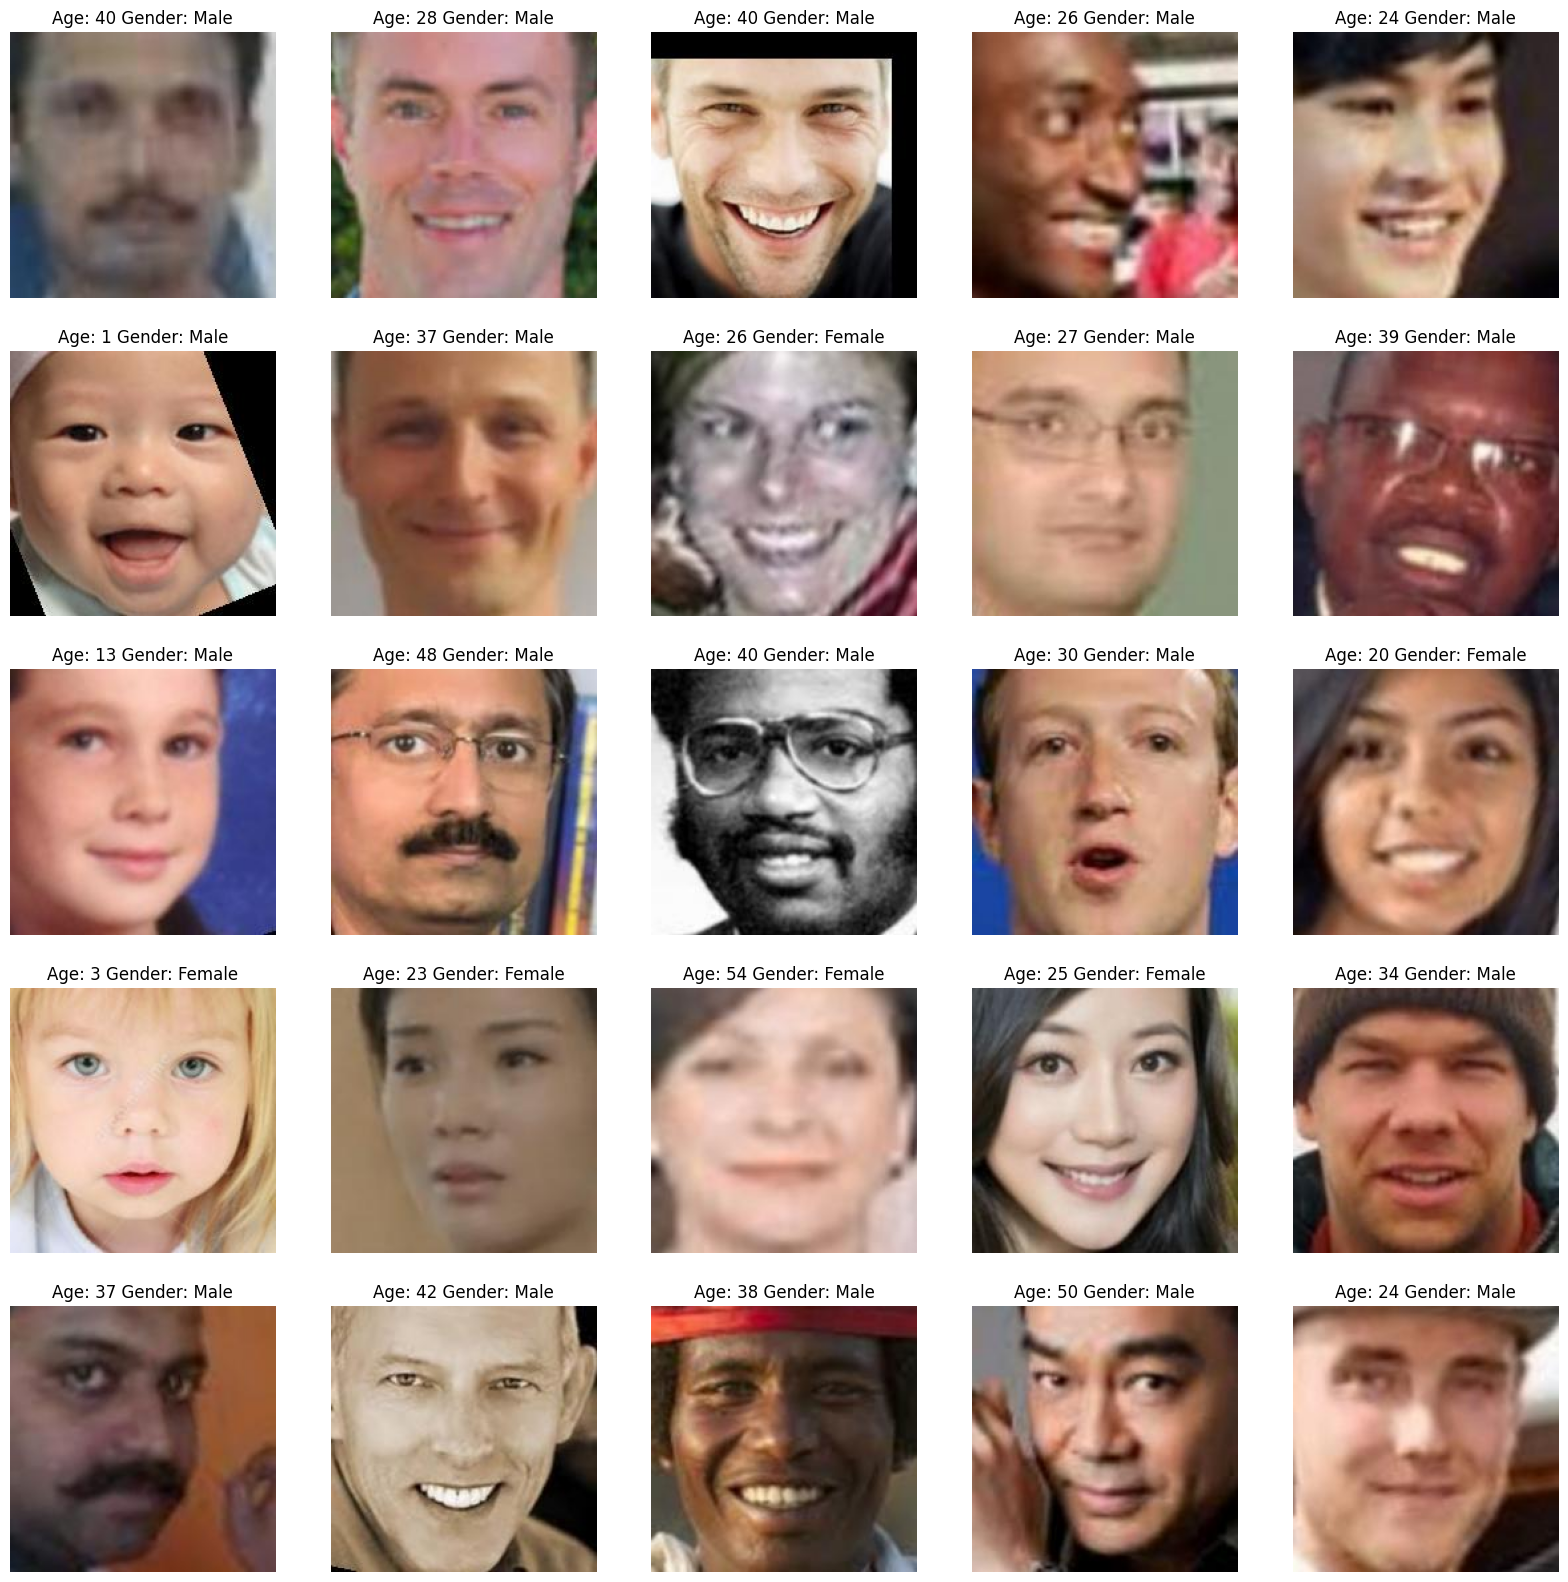

In [14]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [15]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [16]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [17]:
X.shape

(23708, 128, 128, 1)

In [18]:
# normalize the images
X = X/255.0

In [19]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [20]:

input_shape = (128, 128, 1)

In [21]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


In [28]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/30
593/593 [==============================] - 27s 24ms/step - loss: 14.7920 - gender_out_loss: 0.6441 - age_out_loss: 14.1479 - gender_out_accuracy: 0.5987 - age_out_accuracy: 0.0443 - val_loss: 11.0929 - val_gender_out_loss: 0.4985 - val_age_out_loss: 10.5944 - val_gender_out_accuracy: 0.7615 - val_age_out_accuracy: 0.0361
Epoch 2/30
593/593 [==============================] - 12s 20ms/step - loss: 10.7491 - gender_out_loss: 0.4586 - age_out_loss: 10.2905 - gender_out_accuracy: 0.7840 - age_out_accuracy: 0.0212 - val_loss: 9.2526 - val_gender_out_loss: 0.4150 - val_age_out_loss: 8.8377 - val_gender_out_accuracy: 0.8073 - val_age_out_accuracy: 0.0205
Epoch 3/30
593/593 [==============================] - 12s 20ms/step - loss: 9.3575 - gender_out_loss: 0.3970 - age_out_loss: 8.9605 - gender_out_accuracy: 0.8192 - age_out_accuracy: 0.0116 - val_loss: 7.9543 - val_gender_out_loss: 0.3349 - val_age_out_loss: 7.6194 - val_gender_out_accuracy: 0.8444 - val_age_out_accuracy: 0.0044
Epoc

In [38]:
# After training is complete, you can print the accuracy
gender_accuracy = history.history['gender_out_accuracy']
age_accuracy = history.history['age_out_accuracy']

# The last accuracy values in the lists correspond to the final accuracy
final_gender_accuracy = gender_accuracy[-1]
final_age_accuracy = age_accuracy[-1]

print(f'Final Gender Accuracy: {final_gender_accuracy:.2f}')
print(f'Final Age Accuracy: {final_age_accuracy:.2f}')


Final Gender Accuracy: 0.94
Final Age Accuracy: 0.84


Original Gender: Male Original Age: 41
1/1 [==============================] - 0s 229ms/step
Predicted Gender: Male Predicted Age: 42


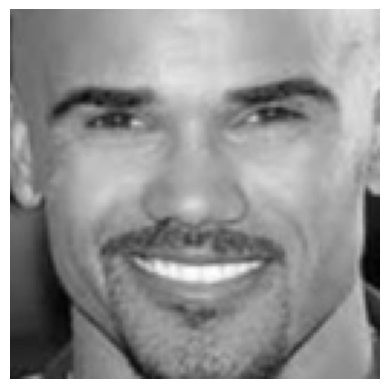

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 22
1/1 [==============================] - 0s 17ms/step
Predicted Gender: Male Predicted Age: 21


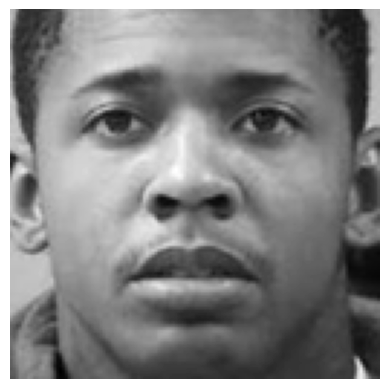

In [ ]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 64
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: 69


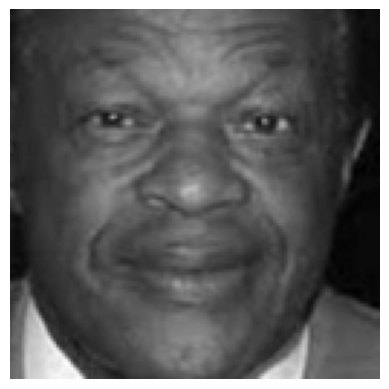

In [ ]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [39]:
# Assuming you have already trained your model and it's stored in the 'model' variable

# Save the model to an HDF5 file
model.save("agegender.h5")

print("Model saved to trained_model.h5")


Model saved to trained_model.h5


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Step 1: Load the saved model
model = load_model('agegender.h5')

# Step 2: Preprocess the input image
def preprocess_image(image_path):
    # Load image in grayscale mode
    img = load_img(image_path, color_mode='grayscale')
    # Resize image
    img = img.resize((128, 128))
    # Convert image to numpy array
    img_array = img_to_array(img)
    # Normalize the image
    img_array = img_array / 255.0
    # Reshape the image (as the model expects 4D input)
    img_array = img_array.reshape(1, 128, 128, 1)
    return img_array

# Replace 'path_to_your_image.jpg' with the path to the image you want to predict
image_path = '/content/IMG_8314.jpg'
input_image = preprocess_image(image_path)

# Step 3: Predict age and gender
predicted_gender, predicted_age = model.predict(input_image)

# Since gender is a binary classification, you might want to convert it to 'Male' or 'Female'
predicted_gender = 'Male' if predicted_gender[0][0] > 0.5 else 'Female'

# Age is a regression output
predicted_age = int(predicted_age[0][0])

# Step 4: Print or return the results
print(f"Predicted Gender: {predicted_gender}")
print(f"Predicted Age: {predicted_age}")
